In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from keras.utils.vis_utils import plot_model
from matplotlib import image
from matplotlib import pyplot as plt
import os 
import time 
from tensorflow import keras
from zipfile import ZipFile
import cv2

In [ ]:
with ZipFile ('/content/drive/MyDrive/Projects/black&white2color/data-20220519T064707Z-001.zip', 'r') as zipobj:
  zipobj.extractall('/content/drive/MyDrive/Projects/black&white2color')

In [ ]:
def image_to_feature_vector(image, size=(120, 120)):
    return cv2.resize(image, size).flatten()

In [ ]:
tf.config.run_functions_eagerly(True)
batch_size = 64
img_size = 120
dataset_split = 2500
ds = '/content/drive/MyDrive/Projects/black&white2color/data'
x = []
y = []
for image_file in os.listdir(ds)[0:dataset_split]:
  rgb_img = Image.open(os.path.join(ds,image_file)).resize((img_size,img_size))
  # Normalization rgb
  rgb_img_array = (np.asarray(rgb_img))/255
  gray_img  = rgb_img.convert('L')
  # Normalization grayscale
  gray_img_array = (np.asarray(gray_img).reshape((img_size,img_size,1)))/255
  # append imgs_array into array x &y
  x.append(gray_img_array)
  y.append(rgb_img_array)

In [ ]:
# train test split
train_x,test_x,train_y,test_y= train_test_split(np.array(x),np.array(y), test_size=0.1)


In [ ]:
# creating dataset
dataset = tf.data.Dataset.from_tensor_slices((train_x,train_y))
dataset = dataset.batch(batch_size)

In [ ]:
#  creating GAN 
def generator_model():
  inputs = tf.keras.layers.Input(shape=(img_size,img_size,1))


  conv1 = tf.keras.layers.Conv2D(16,kernel_size=(5,5),strides=1)(inputs)
  conv1 = tf.keras.layers.LeakyReLU()(conv1)
  conv1 = tf.keras.layers.Conv2D(32,kernel_size=(3,3),strides=1)(conv1)
  conv1 = tf.keras.layers.LeakyReLU()(conv1)
  conv1 = tf.keras.layers.Conv2D(32,kernel_size=(3,3),strides=1)(conv1)
  conv1 = tf.keras.layers.LeakyReLU()(conv1)


  conv2 = tf.keras.layers.Conv2D(32,kernel_size=(5,5),strides=1)(conv1)
  conv2 = tf.keras.layers.LeakyReLU()(conv2)
  conv2 = tf.keras.layers.Conv2D(64,kernel_size=(3,3),strides=1)(conv2)
  conv2 = tf.keras.layers.LeakyReLU()(conv2)
  conv2 = tf.keras.layers.Conv2D(64,kernel_size=(3,3),strides=1)(conv2)
  conv2 = tf.keras.layers.LeakyReLU()(conv2)


  conv3 = tf.keras.layers.Conv2D(64,kernel_size=(5,5),strides=1)(conv2)
  conv3 = tf.keras.layers.LeakyReLU()(conv3)
  conv3 = tf.keras.layers.Conv2D(128,kernel_size=(3,3),strides=1)(conv3)
  conv3 = tf.keras.layers.LeakyReLU()(conv3)
  conv3 = tf.keras.layers.Conv2D(128,kernel_size=(3,3),strides=1)(conv3)
  conv3 = tf.keras.layers.LeakyReLU()(conv3)


  bottleneck = tf.keras.layers.Conv2D(128,kernel_size=(3,3),strides=1,activation='tanh',padding='same')(conv3)
  concat_1 = tf.keras.layers.Concatenate()([bottleneck,conv3])
  conv_up_3 = tf.keras.layers.Conv2DTranspose(128,kernel_size=(3,3),strides=1,activation='relu')(concat_1)
  conv_up_3 = tf.keras.layers.Conv2DTranspose(128,kernel_size=(3,3),strides=1,activation='relu')(conv_up_3)
  conv_up_3 = tf.keras.layers.Conv2DTranspose(64,kernel_size=(5,5),strides=1,activation='relu')(conv_up_3)

  concat_2 = tf.keras.layers.Concatenate()([conv_up_3,conv2])
  conv_up_2 = tf.keras.layers.Conv2DTranspose(64,kernel_size=(3,3),strides=1,activation='relu')(concat_2)
  conv_up_2 = tf.keras.layers.Conv2DTranspose(64,kernel_size=(3,3),strides=1,activation='relu')(conv_up_2)
  conv_up_2 = tf.keras.layers.Conv2DTranspose(32,kernel_size=(5,5),strides=1,activation='relu')(conv_up_2)

  concat_3 = tf.keras.layers.Concatenate()([conv_up_2,conv1])
  conv_up_1 = tf.keras.layers.Conv2DTranspose(32,kernel_size=(3,3),strides=1,activation='relu')(concat_3)
  conv_up_1 = tf.keras.layers.Conv2DTranspose(32,kernel_size=(3,3),strides=1,activation='relu')(conv_up_1)
  conv_up_1 = tf.keras.layers.Conv2DTranspose(3,kernel_size=(5,5),strides=1,activation='relu')(conv_up_1)

  model = tf.keras.models.Model(inputs,conv_up_1)

  return model


  

In [ ]:
# discriminator 
def discriminator_model():
  layers = [
            tf.keras.layers.Conv2D(32,kernel_size=(7,7),strides=1,activation = 'relu', input_shape=(120,120,3)),
            tf.keras.layers.Conv2D(32,kernel_size=(7,7),strides=1,activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(64,kernel_size=(5,5),strides=1,activation='relu'),
            tf.keras.layers.Conv2D(64,kernel_size=(5,5),strides=1,activation='relu'),
            tf.keras.layers.MaxPooling2D(),

            tf.keras.layers.Conv2D(128,kernel_size=(3,3),strides=1,activation='relu'),
            tf.keras.layers.Conv2D(128,kernel_size=(3,3),strides=1,activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(256,kernel_size=(3,3),strides=1,activation='relu'),
            tf.keras.layers.Conv2D(256,kernel_size=(3,3),strides=1,activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512,activation='relu'),
            tf.keras.layers.Dense(128,activation='relu'),
            tf.keras.layers.Dense(16,activation='relu'),
            tf.keras.layers.Dense(1,activation='sigmoid'),
  ]
  model=tf.keras.models.Sequential(layers)
  return model

In [ ]:
# loss functions
cross_entropy  = tf.keras.losses.BinaryCrossentropy()
mean_sqr_error= tf.keras.losses.MeanSquaredError()


def discriminator_loss(real_output,fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output)-tf.random.uniform(shape=real_output.shape,maxval=0.1),real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output)-tf.random.uniform(shape=real_output.shape,maxval=0.1),fake_output)
  total_loss = real_loss+fake_loss
  return total_loss
def generator_loss(fake_output,real_y):
  real_y = tf.cast(real_y,'float32')
  return mean_sqr_error(fake_output,real_y)

generator_optimizer = tf.keras.optimizers.Adam(0.0005)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0005)

generator = generator_model()
discriminator = discriminator_model()


In [ ]:
@tf.function
def train_step(input_x,real_y):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    # generate as Image -> G(x)
    gen_images = generator(input_x,training=True)

    # probability that the given image is real -> D(x)
    real_output = discriminator(real_y,training= True)

    #  probability that the given image is the one generated -> D(G(x))

    gen_output = discriminator(gen_images,training=True)

    # L2, Loss 

    gen_loss = generator_loss(gen_images,real_y)
    #  log loss for Discriminator
    disc_loss = discriminator_loss(real_output,gen_output)

    losses["D"].append(disc_loss.numpy())
    losses["G"].append(gen_loss.numpy())
  #  tf.keras.backend.print_tensor(tf.backend.mean(gen_loss))
  #  tf.keras.backend.print_tensor(gen_loss+disc_loss)

  #  compute the gradients
  gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)


  #  optimizing using Adam
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
generator.compile(
    optimizer = generator_optimizer,
    loss= generator_loss,
    metrics = ['accuracy']
)  
discriminator.compile(
    optimizer= discriminator_optimizer,
    loss = discriminator_loss,
    metrics = ['accuracy']
)


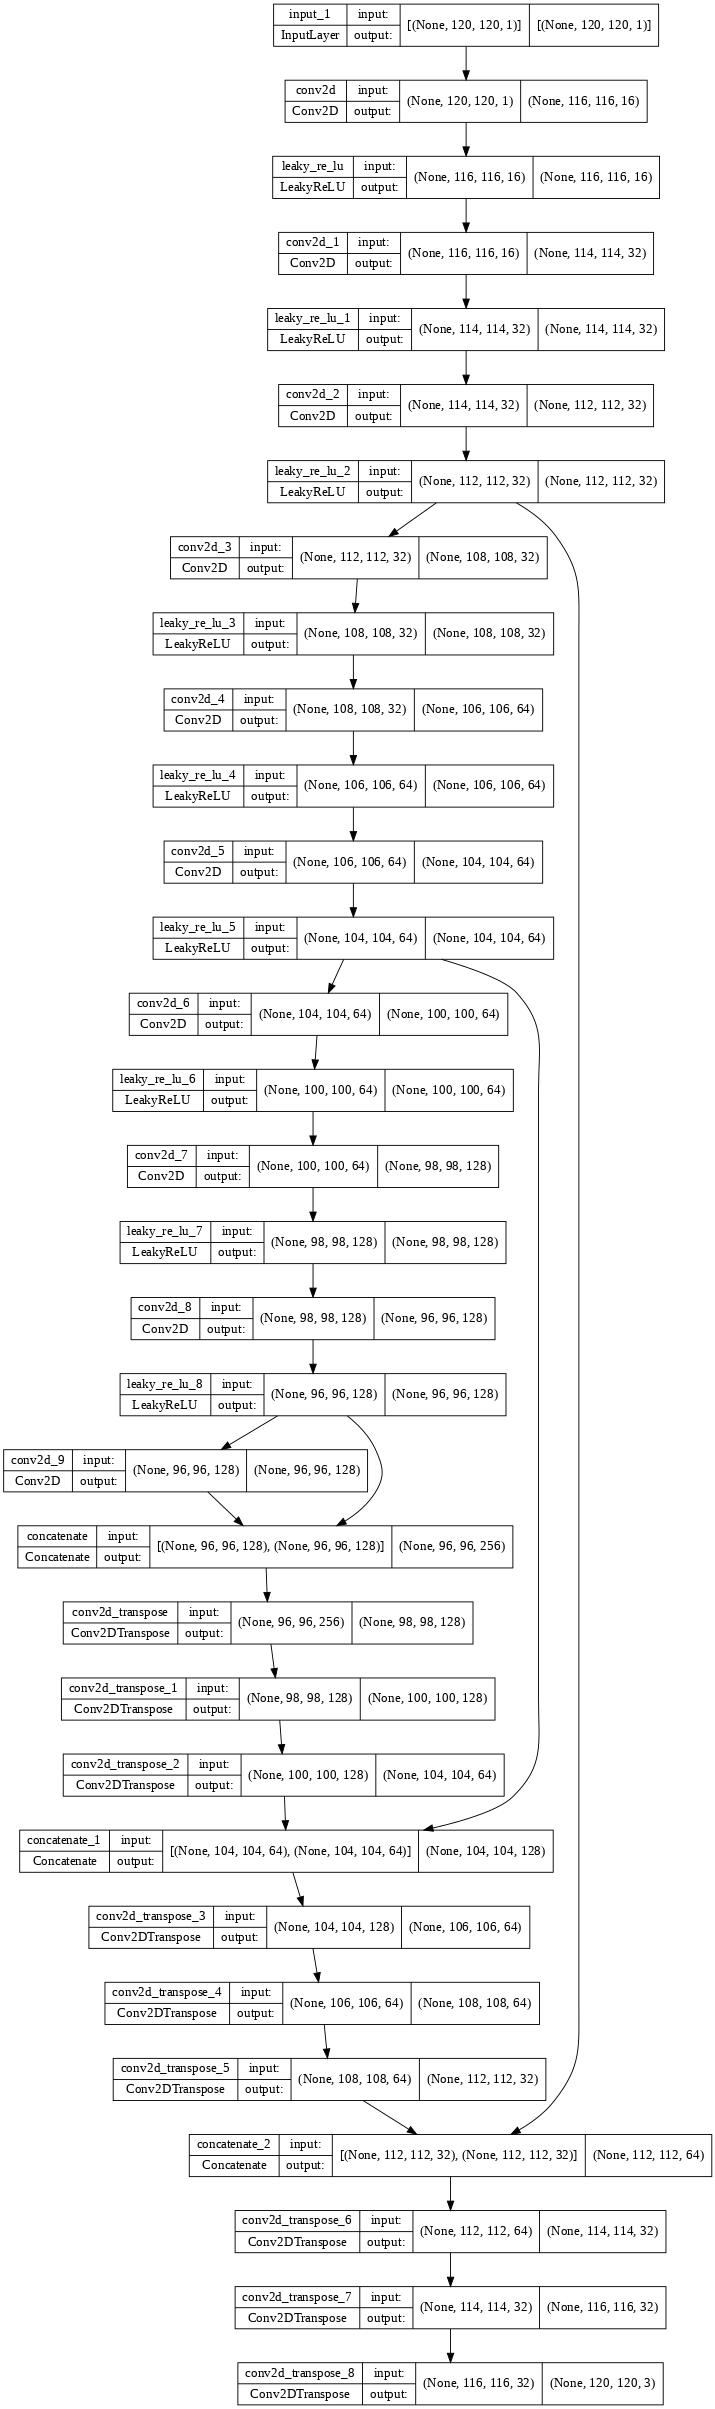

In [ ]:
# visualising the generator model
plot_model(generator, to_file='generator.png',show_shapes=True,show_layer_names=True,dpi=66)

In [ ]:
num_epochs = 50
losses= {"D":[],"G":[]}
for i in range(num_epochs):
  print("running Epoch",i)
  for (x,y) in dataset:
    # x,y are batch in ds
    train_step(x,y)


running Epoch 0
running Epoch 1
running Epoch 2
running Epoch 3
running Epoch 4
running Epoch 5
running Epoch 6
running Epoch 7
running Epoch 8
running Epoch 9
